In [7]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [21]:
 !conda install -c conda-forge vit-pytorch -y

Retrieving notices: ...working... done
Channels:
 - conda-forge
 - rapidsai
 - nvidia
 - defaults
 - pytorch
Platform: linux-64
Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - vit-pytorch


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    blas-1.1                   |         openblas           1 KB  conda-forge
    einops-0.8.0               |     pyhd8ed1ab_0          39 KB  conda-forge
    filelock-3.14.0            |     pyhd8ed1ab_0          16 KB  conda-forge
    gmpy2-2.1.5                |  py310hc7909c9_1         201 KB  conda-forge
    libtorch-2.1.2             |cpu_generic_h7795521_0        45.3 MB  conda-forge
    mpc-1.3.1                  |       hfe3b2da_0         114 KB  conda-forge
    mpfr-4.2.1                 |       h9458935_1         628 KB  conda-forge
    mpmath-1.3.0               |     pyhd8ed1ab_0

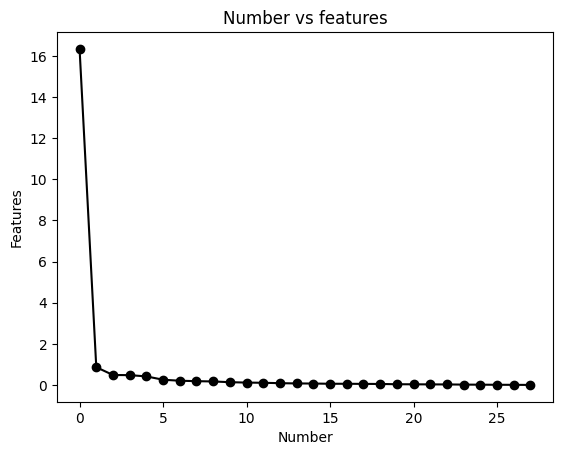

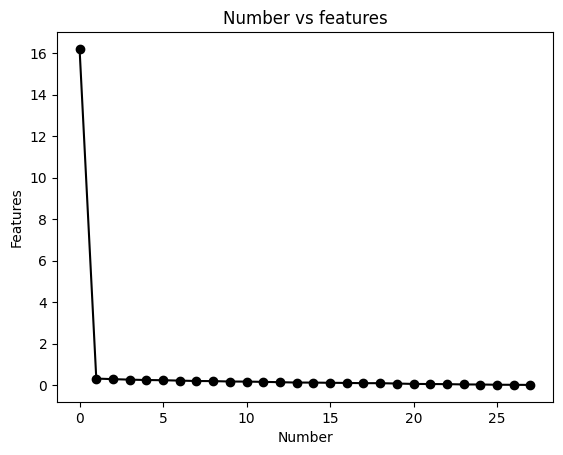

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy of Logistic Regression on training set: 0.82
Accuracy of Logistic Regression on test set: 0.82
Accuracy of Decision Tree on training set: 1.00
Accuracy of Decision Tree on test set: 0.94
Accuracy of K-Nearest Neighbors on training set: 0.93
Accuracy of K-Nearest Neighbors on test set: 0.90
Accuracy of Linear Discriminant Analysis on training set: 0.84
Accuracy of Linear Discriminant Analysis on test set: 0.83
Accuracy of Gaussian Naive Bayes on training set: 0.68
Accuracy of Gaussian Naive Bayes on test set: 0.69
Accuracy of Support Vector Machine on training set: 0.85
Accuracy of Support Vector Machine on test set: 0.85
Accuracy of Random Forest on training set: 1.00
Accuracy of Random Forest on test set: 0.96
Time taken to find the best model: 182.99 seconds
Memory usage: 6598.69 MB
CPU time: 3127.82 seconds
Best model: Random Forest with accuracy: 0.96
[[2570    4   44   37]
 [   0 1934   11   69]
 [  38   23 1706   83]
 [  59   42   36 3344]]
              precision    rec

In [23]:
################### Classical ML Models ######################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imshow
import scipy
import psutil
import time
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

# Load and preprocess data
def image_processing(df_x):
    reshaped_x = df_x.values.reshape(-1, 28, 28, 4).astype(float)
    reshaped_x_new = reshaped_x / 255.0

    x_grey = []
    # Convert images to gray scale
    for i in range(len(reshaped_x_new)):
        grey_image = np.dot(reshaped_x_new[i, :, :, 0:3], [0.2989, 0.5870, 0.1140])
        x_grey.append(grey_image)

    x_grey_np = np.asarray(x_grey)
    reshaped_x_grey = x_grey_np.reshape(-1, 28, 28, 1)
    svd_feat = []
    for i in range(len(reshaped_x_grey)):
        temp = np.asmatrix(reshaped_x_grey[i, :, :, :])
        svd_feat.append(scipy.linalg.svdvals(temp))

    # Plot SVD features
    svd_arr = np.array(svd_feat)
    plt.plot(range(28), svd_feat[1], "-ok")
    plt.xlabel('Number')
    plt.ylabel('Features')
    plt.title('Number vs features')
    plt.show()
    
    # Compute RGB channel means
    r_mean = []
    g_mean = []
    b_mean = []

    for i in range(len(reshaped_x_new)):
        r_mean.append(np.mean(reshaped_x_new[i, :, :, 0]))
        g_mean.append(np.mean(reshaped_x_new[i, :, :, 1]))
        b_mean.append(np.mean(reshaped_x_new[i, :, :, 2]))

    df_means = pd.DataFrame(list(zip(r_mean, g_mean, b_mean)), columns=['R Mean', 'G Mean', 'B Mean'])
    svd_feat_np = np.asarray(svd_feat)
    df_svd_feat = pd.DataFrame(svd_feat_np)

    # Combine SVD features and channel means
    df_X = pd.concat([df_svd_feat, df_means], axis=1)
    df_X.columns = df_X.columns.astype(str)
    initial_len = len(df_X)
    df_X = df_X.dropna()
    return df_X


def label_processing(df_y):
    df_y['Labels'] = "NA"
    for ix in range(len(df_y)):
        if df_y.iloc[ix, 0] == 1:
            df_y.iloc[ix, 4] = "Barren Land"
        elif df_y.iloc[ix, 1] == 1:
            df_y.iloc[ix, 4] = "Trees"
        elif df_y.iloc[ix, 2] == 1:
            df_y.iloc[ix, 4] = "Grassland"
        else:
            df_y.iloc[ix, 4] = "None"
    df_y = df_y['Labels']
    label_map = {"Barren Land": 0, "Trees": 1, "Grassland": 2, "None": 3}
    labels = df_y.map(label_map).values
    return labels



path = "/kaggle/input/deepsat4-subsets/"

df_X_train = pd.read_csv(path + "chunk_x_train_1.csv")
df_y_train = pd.read_csv(path + "chunk_y_train_1.csv")
df_X_test = pd.read_csv(path + "chunk_x_test_1.csv")
df_y_test = pd.read_csv(path + "chunk_y_test_1.csv")


# Drop rows with missing values for training set
df_X_train = df_X_train.dropna()
df_y_train = df_y_train.iloc[df_X_train.index]

# Drop rows with missing values for test set
df_X_test = df_X_test.dropna()
df_y_test = df_y_test.iloc[df_X_test.index]

reshaped_x_train = image_processing(df_X_train)
train_labels = label_processing(df_y_train)

reshaped_x_test = image_processing(df_X_test)
test_labels = label_processing(df_y_test)

# Ensure the labels are in 1D array format
train_labels = train_labels.flatten()
test_labels = test_labels.flatten()


# Initialize classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
    'Gaussian Naive Bayes': GaussianNB(),
    'Support Vector Machine': SVC(),
    'Random Forest': RandomForestClassifier(n_estimators=50)
}

# Start time measurement
start_time = time.time()

# Train and evaluate classifiers
best_model = None
best_score = 0
best_model_name = ""
for name, clf in classifiers.items():
    clf.fit(reshaped_x_train, train_labels)
    train_score = clf.score(reshaped_x_train, train_labels)
    test_score = clf.score(reshaped_x_test, test_labels)
    print(f'Accuracy of {name} on training set: {train_score:.2f}')
    print(f'Accuracy of {name} on test set: {test_score:.2f}')
    if test_score > best_score:
        best_score = test_score
        best_model = clf
        best_model_name = name

end_time = time.time()
time_taken = end_time - start_time

# Measure resource usage
process = psutil.Process()
memory_info = process.memory_info()
cpu_times = process.cpu_times()

print(f'Time taken to find the best model: {time_taken:.2f} seconds')
print(f'Memory usage: {memory_info.rss / (1024 ** 2):.2f} MB')
print(f'CPU time: {cpu_times.user + cpu_times.system:.2f} seconds')

print(f'Best model: {best_model_name} with accuracy: {best_score:.2f}')

# Evaluate the best model
pred = best_model.predict(reshaped_x_test)
print(confusion_matrix(test_labels, pred))
print(classification_report(test_labels, pred))

In [22]:
#################### ViT ####################
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from vit_pytorch import ViT
import time
import psutil

# Define custom dataset
class Sat4Dataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx].astype(np.float32)
        label = self.labels[idx].astype(np.int64)
        
        if self.transform:
            image = self.transform(image)
        
        return image, label
    
# Load and preprocess data
def image_processing(df_x):
    reshaped_X = df_x.values.reshape(-1, 28, 28, 4).astype(float)
    reshaped_X_new = reshaped_X / 255.0
    reshaped_X_rgb = reshaped_X_new[:, :, :, :3]
    return reshaped_X_rgb

def label_processing(df_y):
    df_y['Labels'] = "NA"
    for ix in range(len(df_y)):
        if df_y.iloc[ix, 0] == 1:
            df_y.iloc[ix, 4] = "Barren Land"
        elif df_y.iloc[ix, 1] == 1:
            df_y.iloc[ix, 4] = "Trees"
        elif df_y.iloc[ix, 2] == 1:
            df_y.iloc[ix, 4] = "Grassland"
        else:
            df_y.iloc[ix, 4] = "None"
    df_y = df_y['Labels']
    label_map = {"Barren Land": 0, "Trees": 1, "Grassland": 2, "None": 3}
    labels = df_y.map(label_map).values
    return labels

path = "/kaggle/input/deepsat4-subsets/"

df_x_train = pd.read_csv(path + "chunk_x_train_1.csv")
df_y_train = pd.read_csv(path + "chunk_y_train_1.csv")
df_x_test = pd.read_csv(path + "chunk_x_test_1.csv")
df_y_test = pd.read_csv(path + "chunk_y_test_1.csv")

reshaped_x_train_rgb = image_processing(df_x_train)
train_labels = label_processing(df_y_train)

reshaped_x_test_rgb = image_processing(df_x_test)
test_labels = label_processing(df_y_test)

print("Unique train labels:", np.unique(train_labels))
print("Unique test labels:", np.unique(test_labels))

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = Sat4Dataset(reshaped_x_train_rgb, train_labels, transform)
test_dataset = Sat4Dataset(reshaped_x_test_rgb, test_labels, transform)
train_size = len(train_dataset)
test_size = len(test_dataset)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Check if GPU is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Initialize ViT model, loss function, and optimizer
model = ViT(
    image_size = 224,
    patch_size = 32,
    num_classes = 4,
    dim = 1024,
    depth = 6,
    heads = 16,
    mlp_dim = 2048,
    dropout = 0.1,
    emb_dropout = 0.1
).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Measure start time and resource usage
start_time = time.time()
process = psutil.Process()

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move images and labels to GPU
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}')

# Measure end time and resource usage
end_time = time.time()
time_taken = end_time - start_time
memory_info = process.memory_info()
cpu_times = process.cpu_times()

print(f'Time taken to train the model: {time_taken:.2f} seconds')
print(f'Memory usage: {memory_info.rss / (1024 ** 2):.2f} MB')
print(f'CPU time: {cpu_times.user + cpu_times.system:.2f} seconds')

# Evaluation
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)  # Move images and labels to GPU
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Confusion matrix and classification report
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))


Unique train labels: [0 1 2 3]
Unique test labels: [0 1 2 3]
cuda


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 1/10, Loss: 0.8519095879457795
Epoch 2/10, Loss: 0.7385933524964715
Epoch 3/10, Loss: 0.7487748293849208
Epoch 4/10, Loss: 0.7298540312158482
Epoch 5/10, Loss: 0.7249136074729587
Epoch 6/10, Loss: 0.7151487050458903
Epoch 7/10, Loss: 0.6959304028688489
Epoch 8/10, Loss: 0.7374428406624538
Epoch 9/10, Loss: 0.7227508773660416
Epoch 10/10, Loss: 0.7359507107140159
Time taken to train the model: 1901.82 seconds
Memory usage: 6439.40 MB
CPU time: 2836.96 seconds
[[2498    6   38  113]
 [   5 1577   11  421]
 [1130   51  276  393]
 [ 157 1214   60 2050]]
              precision    recall  f1-score   support

           0       0.66      0.94      0.78      2655
           1       0.55      0.78      0.65      2014
           2       0.72      0.15      0.25      1850
           3       0.69      0.59      0.63      3481

    accuracy                           0.64     10000
   macro avg       0.65      0.62      0.58     10000
weighted avg       0.66      0.64      0.60     10000



In [ ]:
################## ResNet ######################
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, models
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import psutil
import time


# Define custom dataset
class Sat4Dataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx].astype(np.float32)
        label = self.labels[idx].astype(np.int64)
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Load pre-trained ResNet and modify it for our task
class ResNetModel(nn.Module):
    def __init__(self):
        super(ResNetModel, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 4)
    
    def forward(self, x):
        return self.resnet(x)


def image_processing(df_x):
    reshaped_X = df_x.values.reshape(-1, 28, 28, 4).astype(float)
    reshaped_X_new = reshaped_X / 255.0
    reshaped_X_rgb = reshaped_X_new[:, :, :, :3]
    return reshaped_X_rgb

def label_processing(df_y):
    df_y['Labels'] = "NA"
    for ix in range(len(df_y)):
        if df_y.iloc[ix, 0] == 1:
            df_y.iloc[ix, 4] = "Barren Land"
        elif df_y.iloc[ix, 1] == 1:
            df_y.iloc[ix, 4] = "Trees"
        elif df_y.iloc[ix, 2] == 1:
            df_y.iloc[ix, 4] = "Grassland"
        else:
            df_y.iloc[ix, 4] = "None"
    df_y = df_y['Labels']
    label_map = {"Barren Land": 0, "Trees": 1, "Grassland": 2, "None": 3}
    labels = df_y.map(label_map).values
    return labels

path = "/kaggle/input/deepsat4-subsets/"

df_x_train = pd.read_csv(path + "chunk_x_train_1.csv")
df_y_train = pd.read_csv(path + "chunk_y_train_1.csv")
df_x_test = pd.read_csv(path + "chunk_x_test_1.csv")
df_y_test = pd.read_csv(path + "chunk_y_test_1.csv")

reshaped_x_train_rgb = image_processing(df_x_train)
train_labels = label_processing(df_y_train)

reshaped_x_test_rgb = image_processing(df_x_test)
test_labels = label_processing(df_y_test)

print("Unique train labels:", np.unique(train_labels))
print("Unique test labels:", np.unique(test_labels))

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = Sat4Dataset(reshaped_x_train_rgb, train_labels, transform)
test_dataset = Sat4Dataset(reshaped_x_test_rgb, test_labels, transform)
train_size = len(train_dataset)
test_size = len(test_dataset)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Check if GPU is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Initialize model, loss function, and optimizer
model = ResNetModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Measure start time and resource usage
start_time = time.time()
process = psutil.Process()

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move images and labels to GPU
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}')

# Measure end time and resource usage
end_time = time.time()
time_taken = end_time - start_time
memory_info = process.memory_info()
cpu_times = process.cpu_times()

print(f'Time taken to train the model: {time_taken:.2f} seconds')
print(f'Memory usage: {memory_info.rss / (1024 ** 2):.2f} MB')
print(f'CPU time: {cpu_times.user + cpu_times.system:.2f} seconds')

# Evaluation
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)  # Move images and labels to GPU
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Confusion matrix and classification report
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))


Unique train labels: [0 1 2 3]
Unique test labels: [0 1 2 3]
cuda


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 163MB/s]
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomRes

Epoch 1/10, Loss: 0.09520092789280822
Epoch 2/10, Loss: 0.04846923733847645
Epoch 3/10, Loss: 0.03710568104410613
Epoch 4/10, Loss: 0.03626717884576453
Epoch 5/10, Loss: 0.0234782246443036
Epoch 6/10, Loss: 0.020115810567773815


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import psutil
import time
import scipy.linalg

# Define custom dataset
class Sat4Dataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx].astype(np.float32)
        label = self.labels[idx].astype(np.int64)
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Load pre-trained ResNet and modify it for our task
class ResNetModel(nn.Module):
    def __init__(self):
        super(ResNetModel, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 4)
    
    def forward(self, x):
        return self.resnet(x)

# Define ViT model
from vit_pytorch import ViT

class ViTModel(nn.Module):
    def __init__(self):
        super(ViTModel, self).__init__()
        self.vit = ViT(
            image_size = 224,
            patch_size = 32,
            num_classes = 4,
            dim = 1024,
            depth = 6,
            heads = 16,
            mlp_dim = 2048,
            dropout = 0.1,
            emb_dropout = 0.1
        )
    
    def forward(self, x):
        return self.vit(x)

def image_processing_regular_classification(df_x):
    reshaped_x = df_x.values.reshape(-1, 28, 28, 4).astype(float)
    reshaped_x_new = reshaped_x / 255.0

    x_grey = []
    # Convert images to gray scale
    for i in range(len(reshaped_x_new)):
        grey_image = np.dot(reshaped_x_new[i, :, :, 0:3], [0.2989, 0.5870, 0.1140])
        x_grey.append(grey_image)

    x_grey_np = np.asarray(x_grey)
    reshaped_x_grey = x_grey_np.reshape(-1, 28, 28, 1)
    svd_feat = []
    for i in range(len(reshaped_x_grey)):
        temp = np.asmatrix(reshaped_x_grey[i, :, :, :])
        svd_feat.append(scipy.linalg.svdvals(temp))

    # Compute RGB channel means
    r_mean = []
    g_mean = []
    b_mean = []

    for i in range(len(reshaped_x_new)):
        r_mean.append(np.mean(reshaped_x_new[i, :, :, 0]))
        g_mean.append(np.mean(reshaped_x_new[i, :, :, 1]))
        b_mean.append(np.mean(reshaped_x_new[i, :, :, 2]))

    df_means = pd.DataFrame(list(zip(r_mean, g_mean, b_mean)), columns=['R Mean', 'G Mean', 'B Mean'])
    svd_feat_np = np.asarray(svd_feat)
    df_svd_feat = pd.DataFrame(svd_feat_np)

    # Combine SVD features and channel means
    df_X = pd.concat([df_svd_feat, df_means], axis=1)
    df_X.columns = df_X.columns.astype(str)
    initial_len = len(df_X)
    df_X = df_X.dropna()
    return df_X

def image_processing(df_x):
    reshaped_X = df_x.values.reshape(-1, 28, 28, 4).astype(float)
    reshaped_X_new = reshaped_X / 255.0
    reshaped_X_rgb = reshaped_X_new[:, :, :, :3]
    return reshaped_X_rgb

def label_processing(df_y):
    df_y['Labels'] = "NA"
    for ix in range(len(df_y)):
        if df_y.iloc[ix, 0] == 1:
            df_y.iloc[ix, 4] = "Barren Land"
        elif df_y.iloc[ix, 1] == 1:
            df_y.iloc[ix, 4] = "Trees"
        elif df_y.iloc[ix, 2] == 1:
            df_y.iloc[ix, 4] = "Grassland"
        else:
            df_y.iloc[ix, 4] = "None"
    df_y = df_y['Labels']
    label_map = {"Barren Land": 0, "Trees": 1, "Grassland": 2, "None": 3}
    labels = df_y.map(label_map).values
    return labels

path = "/kaggle/input/deepsat4-subsets/"

df_x_train = pd.read_csv(path + "chunk_x_train_1.csv")
df_y_train = pd.read_csv(path + "chunk_y_train_1.csv")
df_x_test = pd.read_csv(path + "chunk_x_test_1.csv")
df_y_test = pd.read_csv(path + "chunk_y_test_1.csv")

train_labels = label_processing(df_y_train)
test_labels = label_processing(df_y_test)

# Data preprocessing for regular classifiers
reshaped_x_train_regular = image_processing_regular_classification(df_x_train)
reshaped_x_test_regular = image_processing_regular_classification(df_x_test)

# Data preprocessing for ViT and ResNet
reshaped_x_train_rgb = image_processing(df_x_train)
reshaped_x_test_rgb = image_processing(df_x_test)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = Sat4Dataset(reshaped_x_train_rgb, train_labels, transform)
test_dataset = Sat4Dataset(reshaped_x_test_rgb, test_labels, transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Check if GPU is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

def train_and_evaluate_model(model, train_loader, test_loader, num_epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    start_time = time.time()
    process = psutil.Process()
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)  # Move images and labels to GPU
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
    
    end_time = time.time()
    time_taken = end_time - start_time
    memory_info = process.memory_info()
    cpu_times = process.cpu_times()
    
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)  # Move images and labels to GPU
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    return {
        "time_taken": time_taken,
        "memory_usage": memory_info.rss / (1024 ** 2),
        "cpu_time": cpu_times.user + cpu_times.system,
        "confusion_matrix": confusion_matrix(y_true, y_pred),
        "classification_report": classification_report(y_true, y_pred, output_dict=True)
    }

# Regular classifiers
def train_and_evaluate_classifiers(X_train, y_train, X_test, y_test):
    classifiers = {
        'Logistic Regression': LogisticRegression(),
        'Decision Tree': DecisionTreeClassifier(),
        'K-Nearest Neighbors': KNeighborsClassifier(),
        'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
        'Gaussian Naive Bayes': GaussianNB(),
        'Support Vector Machine': SVC(),
        'Random Forest': RandomForestClassifier(n_estimators=50)
    }

    start_time = time.time()
    process = psutil.Process()
    
    best_model = None
    best_score = 0
    best_model_name = ""
    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        test_score = clf.score(X_test, y_test)
        if test_score > best_score:
            best_score = test_score
            best_model = clf
            best_model_name = name
    
    end_time = time.time()
    time_taken = end_time - start_time
    memory_info = process.memory_info()
    cpu_times = process.cpu_times()
    
    y_pred = best_model.predict(X_test)
    
    return {
        "time_taken": time_taken,
        "memory_usage": memory_info.rss / (1024 ** 2),
        "cpu_time": cpu_times.user + cpu_times.system,
        "confusion_matrix": confusion_matrix(y_test, y_pred),
        "classification_report": classification_report(y_test, y_pred, output_dict=True),
        "best_model_name": best_model_name,
        "best_model_score": best_score
    }

# Evaluate regular classifiers
results_regular = train_and_evaluate_classifiers(reshaped_x_train_regular, train_labels, reshaped_x_test_regular, test_labels)

# Evaluate ViT model
vit_model = ViTModel().to(device)
results_vit = train_and_evaluate_model(vit_model, train_loader, test_loader)

# Evaluate ResNet model
resnet_model = ResNetModel().to(device)
results_resnet = train_and_evaluate_model(resnet_model, train_loader, test_loader)

# Print results
print("Regular Classifiers:")
print(f"Best Model: {results_regular['best_model_name']} with accuracy: {results_regular['best_model_score']:.2f}")
print(f"Time taken: {results_regular['time_taken']:.2f} seconds")
print(f"Memory usage: {results_regular['memory_usage']:.2f} MB")
print(f"CPU time: {results_regular['cpu_time']:.2f} seconds")
print("Confusion Matrix:")
print(results_regular['confusion_matrix'])
print("Classification Report:")
print(pd.DataFrame(results_regular['classification_report']).transpose())

print("\nViT Model:")
print(f"Time taken: {results_vit['time_taken']:.2f} seconds")
print(f"Memory usage: {results_vit['memory_usage']:.2f} MB")
print(f"CPU time: {results_vit['cpu_time']:.2f} seconds")
print("Confusion Matrix:")
print(results_vit['confusion_matrix'])
print("Classification Report:")
print(pd.DataFrame(results_vit['classification_report']).transpose())

print("\nResNet Model:")
print(f"Time taken: {results_resnet['time_taken']:.2f} seconds")
print(f"Memory usage: {results_resnet['memory_usage']:.2f} MB")
print(f"CPU time: {results_resnet['cpu_time']:.2f} seconds")
print("Confusion Matrix:")
print(results_resnet['confusion_matrix'])
print("Classification Report:")
print(pd.DataFrame(results_resnet['classification_report']).transpose())


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import psutil
import time
import scipy.linalg

# Define custom dataset
class Sat4Dataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx].astype(np.float32)
        label = self.labels[idx].astype(np.int64)
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Load pre-trained ResNet and modify it for our task
class ResNetModel(nn.Module):
    def __init__(self):
        super(ResNetModel, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 4)
    
    def forward(self, x):
        return self.resnet(x)

# Define ViT model
from vit_pytorch import ViT

class ViTModel(nn.Module):
    def __init__(self):
        super(ViTModel, self).__init__()
        self.vit = ViT(
            image_size = 224,
            patch_size = 32,
            num_classes = 4,
            dim = 1024,
            depth = 6,
            heads = 16,
            mlp_dim = 2048,
            dropout = 0.1,
            emb_dropout = 0.1
        )
    
    def forward(self, x):
        return self.vit(x)

def image_processing_regular_classification(df_x):
    reshaped_x = df_x.values.reshape(-1, 28, 28, 4).astype(float)
    reshaped_x_new = reshaped_x / 255.0

    x_grey = []
    # Convert images to gray scale
    for i in range(len(reshaped_x_new)):
        grey_image = np.dot(reshaped_x_new[i, :, :, 0:3], [0.2989, 0.5870, 0.1140])
        x_grey.append(grey_image)

    x_grey_np = np.asarray(x_grey)
    reshaped_x_grey = x_grey_np.reshape(-1, 28, 28, 1)
    svd_feat = []
    for i in range(len(reshaped_x_grey)):
        temp = np.asmatrix(reshaped_x_grey[i, :, :, :])
        svd_feat.append(scipy.linalg.svdvals(temp))

    # Compute RGB channel means
    r_mean = []
    g_mean = []
    b_mean = []

    for i in range(len(reshaped_x_new)):
        r_mean.append(np.mean(reshaped_x_new[i, :, :, 0]))
        g_mean.append(np.mean(reshaped_x_new[i, :, :, 1]))
        b_mean.append(np.mean(reshaped_x_new[i, :, :, 2]))

    df_means = pd.DataFrame(list(zip(r_mean, g_mean, b_mean)), columns=['R Mean', 'G Mean', 'B Mean'])
    svd_feat_np = np.asarray(svd_feat)
    df_svd_feat = pd.DataFrame(svd_feat_np)

    # Combine SVD features and channel means
    df_X = pd.concat([df_svd_feat, df_means], axis=1)
    df_X.columns = df_X.columns.astype(str)
    initial_len = len(df_X)
    df_X = df_X.dropna()
    return df_X

def image_processing(df_x):
    reshaped_X = df_x.values.reshape(-1, 28, 28, 4).astype(float)
    reshaped_X_new = reshaped_X / 255.0
    reshaped_X_rgb = reshaped_X_new[:, :, :, :3]
    return reshaped_X_rgb

def label_processing(df_y):
    df_y['Labels'] = "NA"
    for ix in range(len(df_y)):
        if df_y.iloc[ix, 0] == 1:
            df_y.iloc[ix, 4] = "Barren Land"
        elif df_y.iloc[ix, 1] == 1:
            df_y.iloc[ix, 4] = "Trees"
        elif df_y.iloc[ix, 2] == 1:
            df_y.iloc[ix, 4] = "Grassland"
        else:
            df_y.iloc[ix, 4] = "None"
    df_y = df_y['Labels']
    label_map = {"Barren Land": 0, "Trees": 1, "Grassland": 2, "None": 3}
    labels = df_y.map(label_map).values
    return labels

def train_and_evaluate_model(model, train_loader, test_loader, num_epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    start_time = time.time()
    process = psutil.Process()
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)  # Move images and labels to GPU
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
    
    end_time = time.time()
    time_taken = end_time - start_time
    memory_info = process.memory_info()
    cpu_times = process.cpu_times()
    
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)  # Move images and labels to GPU
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    return {
        "time_taken": time_taken,
        "memory_usage": memory_info.rss / (1024 ** 2),
        "cpu_time": cpu_times.user + cpu_times.system,
        "confusion_matrix": confusion_matrix(y_true, y_pred),
        "classification_report": classification_report(y_true, y_pred, output_dict=True)
    }

def train_and_evaluate_classifiers(X_train, y_train, X_test, y_test):
    classifiers = {
        'Logistic Regression': LogisticRegression(),
        'Decision Tree': DecisionTreeClassifier(),
        'K-Nearest Neighbors': KNeighborsClassifier(),
        'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
        'Gaussian Naive Bayes': GaussianNB(),
        'Support Vector Machine': SVC(),
        'Random Forest': RandomForestClassifier(n_estimators=50)
    }

    start_time = time.time()
    process = psutil.Process()
    
    best_model = None
    best_score = 0
    best_model_name = ""
    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        test_score = clf.score(X_test, y_test)
        if test_score > best_score:
            best_score = test_score
            best_model = clf
            best_model_name = name
    
    end_time = time.time()
    time_taken = end_time - start_time
    memory_info = process.memory_info()
    cpu_times = process.cpu_times()
    
    y_pred = best_model.predict(X_test)
    
    return {
        "time_taken": time_taken,
        "memory_usage": memory_info.rss / (1024 ** 2),
        "cpu_time": cpu_times.user + cpu_times.system,
        "confusion_matrix": confusion_matrix(y_test, y_pred),
        "classification_report": classification_report(y_test, y_pred, output_dict=True),
        "best_model_name": best_model_name,
        "best_model_score": best_score
    }

# Function to aggregate results
def aggregate_results(results_list):
    aggregated = {
        "time_taken": sum([r['time_taken'] for r in results_list]),
        "memory_usage": sum([r['memory_usage'] for r in results_list]),
        "cpu_time": sum([r['cpu_time'] for r in results_list]),
        "confusion_matrix": np.sum([r['confusion_matrix'] for r in results_list], axis=0),
        "classification_report": {}
    }
    
    for key in results_list[0]['classification_report']:
        aggregated['classification_report'][key] = {}
        for metric in results_list[0]['classification_report'][key]:
            aggregated['classification_report'][key][metric] = np.mean([r['classification_report'][key][metric] for r in results_list])

    return aggregated

# Paths to data chunks
chunk_train_files = [f"/kaggle/input/deepsat4-subsets/chunk_x_train_{i}.csv" for i in range(1, 9)]
chunk_train_labels = [f"/kaggle/input/deepsat4-subsets/chunk_y_train_{i}.csv" for i in range(1, 9)]
chunk_test_files = [f"/kaggle/input/deepsat4-subsets/chunk_x_test_{i}.csv" for i in range(1, 9)]
chunk_test_labels = [f"/kaggle/input/deepsat4-subsets/chunk_y_test_{i}.csv" for i in range(1, 9)]

# Aggregated results
results_regular_list = []
results_vit_list = []
results_resnet_list = []

# Process each chunk
for train_file, train_label_file, test_file, test_label_file in zip(chunk_train_files, chunk_train_labels, chunk_test_files, chunk_test_labels):
    df_x_train = pd.read_csv(train_file)
    df_y_train = pd.read_csv(train_label_file)
    df_x_test = pd.read_csv(test_file)
    df_y_test = pd.read_csv(test_label_file)

    train_labels = label_processing(df_y_train)
    test_labels = label_processing(df_y_test)

    # Data preprocessing for regular classifiers
    reshaped_x_train_regular = image_processing_regular_classification(df_x_train)
    reshaped_x_test_regular = image_processing_regular_classification(df_x_test)

    # Data preprocessing for ViT and ResNet
    reshaped_x_train_rgb = image_processing(df_x_train)
    reshaped_x_test_rgb = image_processing(df_x_test)

    train_dataset = Sat4Dataset(reshaped_x_train_rgb, train_labels, transform)
    test_dataset = Sat4Dataset(reshaped_x_test_rgb, test_labels, transform)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    # Evaluate regular classifiers
    results_regular = train_and_evaluate_classifiers(reshaped_x_train_regular, train_labels, reshaped_x_test_regular, test_labels)
    results_regular_list.append(results_regular)

    # Evaluate ViT model
    vit_model = ViTModel().to(device)
    results_vit = train_and_evaluate_model(vit_model, train_loader, test_loader)
    results_vit_list.append(results_vit)

    # Evaluate ResNet model
    resnet_model = ResNetModel().to(device)
    results_resnet = train_and_evaluate_model(resnet_model, train_loader, test_loader)
    results_resnet_list.append(results_resnet)

# Aggregate results
aggregated_results_regular = aggregate_results(results_regular_list)
aggregated_results_vit = aggregate_results(results_vit_list)
aggregated_results_resnet = aggregate_results(results_resnet_list)

# Print aggregated results
print("Aggregated Regular Classifiers:")
print(f"Time taken: {aggregated_results_regular['time_taken']:.2f} seconds")
print(f"Memory usage: {aggregated_results_regular['memory_usage']:.2f} MB")
print(f"CPU time: {aggregated_results_regular['cpu_time']:.2f} seconds")
print("Confusion Matrix:")
print(aggregated_results_regular['confusion_matrix'])
print("Classification Report:")
print(pd.DataFrame(aggregated_results_regular['classification_report']).transpose())

print("\nAggregated ViT Model:")
print(f"Time taken: {aggregated_results_vit['time_taken']:.2f} seconds")
print(f"Memory usage: {aggregated_results_vit['memory_usage']:.2f} MB")
print(f"CPU time: {aggregated_results_vit['cpu_time']:.2f} seconds")
print("Confusion Matrix:")
print(aggregated_results_vit['confusion_matrix'])
print("Classification Report:")
print(pd.DataFrame(aggregated_results_vit['classification_report']).transpose())

print("\nAggregated ResNet Model:")
print(f"Time taken: {aggregated_results_resnet['time_taken']:.2f} seconds")
print(f"Memory usage: {aggregated_results_resnet['memory_usage']:.2f} MB")
print(f"CPU time: {aggregated_results_resnet['cpu_time']:.2f} seconds")
print("Confusion Matrix:")
print(aggregated_results_resnet['confusion_matrix'])
print("Classification Report:")
print(pd.DataFrame(aggregated_results_resnet['classification_report']).transpose())
